# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Some details about our data



|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|





In [3]:
# Read in the dataset from the ab_data.csv file and take a look at the top few rows here:
df = pd.read_csv('ab_data.csv')
df.head(20)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
7,719014,2017-01-17 01:48:29.539573,control,old_page,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [4]:
# Find the number of rows in the dataset.
df.shape[0]

294478

In [5]:
# The number of unique users in the dataset.
df.user_id.nunique()

290584

In [6]:
# The proportion of users converted.
df.converted.mean()

0.11965919355605512

In [7]:
# The number of times when the "group" is treatment but "landing_page" is not a new_page.
df.query('group == "treatment" & landing_page != "new_page"').shape[0]

1965

In [8]:
#  Do any of the rows have missing values?
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64



In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  



In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)


In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# How many unique user_ids are in df2?
df2.user_id.nunique()

290584

In [12]:
# There is one user_id repeated in df2. What is it?
df2[df2.user_id.duplicated() == True].index[0]

2893

In [13]:
# Display the rows for the duplicate user_id?
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(df2[df2.user_id.duplicated() == True].index, inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2.user_id.duplicated().any()

False

In [15]:
# What is the probability of an individual converting regardless of the page they receive?
p_all_converted = df2.converted.mean()
p_all_converted

0.11959708724499628

In [16]:
# Given that an individual was in the control group, what is the probability they converted?
p_control_converted = df2.query('group == "control"').converted.mean()
p_control_converted

0.1203863045004612

In [17]:
# Given that an individual was in the treatment group, what is the probability they converted?
p_treatment_converted = df2.query('group == "treatment"').converted.mean()
p_treatment_converted

0.11880806551510564

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treatment_converted - p_control_converted
obs_diff

-0.0015782389853555567

In [19]:
# What is the probability that an individual received the new page?
p_new_page = df2.query('landing_page == "new_page"').shape[0] / \
             df2.shape[0]
p_new_page

0.5000619442226688

**Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.**

>**My answer:**
> - The treatment group does not lead to more conversions because the proportion of the users converted of treatment group is less than the one of control group

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  



For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**My answer:**
$$H_0: P_{new} - P_{old} <= 0 $$
$$H_1: P_{new} - P_{old} > 0 $$

### 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, We will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 





**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [22]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

In [24]:
# p_new - p_old under the null.
p_new - p_old

0.0

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [26]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
p_sim_new = new_page_converted.mean()
p_sim_new

0.11800289037230748

In [28]:
p_sim_old = old_page_converted.mean()
p_sim_old

0.1185965830086595

In [29]:
# p_sim_new - p_sim_old
p_sim_diff = p_sim_new - p_sim_old
p_sim_diff

-0.0005936926363520195


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [30]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
    p_sim2_new = new_page_converted.mean()
    p_sim2_old = old_page_converted.mean()
    p_diffs.append(p_sim2_new - p_sim2_old)
    

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


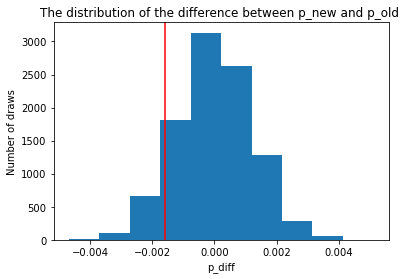

In [31]:
plt.hist(p_diffs)
plt.title('The distribution of the difference between p_new and p_old ')
plt.xlabel('p_diff')
plt.ylabel('Number of draws')
plt.axvline(x=obs_diff, color='r');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [40]:
p_diffs = np.array(p_diffs)
P_val = (p_diffs > obs_diff).mean()
P_val

0.9007

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**My answer:**
 - This valu is called the P-value.
 - This value signifies that we failed to reject the null hypothesis ($H_o: p_{new}$ = $p_{old}$ = $p_{population}$) because it is greater than the "Type I error rate (0.05)".



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [41]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]

# number of individuals who were shown the old_page
n_old = df.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df.query('landing_page == "new_page"').shape[0]

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

>**Tip**: You don't have to dive deeper into z-test for this exercise. **Try having an overview of what does z-score signify in general.** 

In [42]:
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print("Z-score: ",z_score,"\n","P-value:",p_value)

Z-score:  -1.2851562063649145 
 P-value: 0.9006311481555165


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>**My answer:**
> - It means that we failed to reject the null hypothesis($H_o: p_{new}$ = $p_{old}$ = $p_{population}$) because the P-valu is greater than the "Type I error rate (0.05)" and the $Z_{score}$ < $Z_{\alpha}$.
> - Yes, they agree with the findings in parts **j.** and **k.**

<a id='regression'></a>
### Part III - A regression approach


In this final part, we will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>** My answer.**
>- Logistic regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [43]:
df2['intercept'] = 1
df2[['convert', 'not_convert']] = pd.get_dummies(df2['converted'])
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,convert,not_convert,ab_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,1


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [44]:
log_mod = sm.Logit(df2.convert, df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.112142
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [45]:
results.summary2()

C:\Users\Master\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Master\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Master\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: inf       
Dependent Variable: convert          AIC:              65177.0594
Date:               2021-12-29 20:01 BIC:              65198.2187
No. Observations:   290584           Log-Likelihood:   -32587.   
Df Model:           1                LL-Null:          0.0000    
Df Residuals:       290582           LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025  0.975]
------------------------------------------------------------------
intercept      1.9888    0.0081  246.6690  0.0000   1.9730  2.0046
ab_page        0.0150    0.0114    1.3109  0.1899  -0.0074  0.0374
=================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>** My answer:**
> - The P-value = 0.1899
> - The P-value her is different from **Part||** because the null and alternative hypotheses($H_o: p_{new}$ = $p_{old}$ = $p_{population}$ & $H_1: p_{new} > p_{old}$) of **Part||** is different from the null and alternative hypotheses($H_o: \beta_{i} = 0$ & $H_1: \beta_{i} \neq 0$)of **Part|||**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**My answer:**
> - It is a good idea to consider other factors to add into your model because it enables us to have more accuracy intution about our model and what affect our response
> - yes, there are some disadvantages like:
> - our features are correlated to each other which will give me unaccurate resultes 
> - using many features will increase our coputational time and power 

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in.  

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [46]:
# Read the countries.csv
df_count = pd.read_csv('countries.csv')
df_count.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
# Join with the df2 dataframe
df_merged = df2.merge(df_count, how='outer')
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,convert,not_convert,ab_page,old_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,1,US


In [48]:
# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,timestamp,group,landing_page,converted,intercept,convert,not_convert,ab_page,old_page,country,UK,US,CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,1,US,0,0,1


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 
 

In [50]:
# Fit your model, and summarize the results
df_merged['ab_page_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_page_US'] = df_merged['ab_page'] * df_merged['US']
log_mod2 = sm.Logit(df_merged.convert, df_merged[['intercept', 'ab_page', 'UK', 'US', 'ab_page_UK', 'ab_page_US']])
results2 = log_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.112140
         Iterations 6


C:\Users\Master\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Master\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Master\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: inf       
Dependent Variable: convert          AIC:              65184.3894
Date:               2021-12-29 20:03 BIC:              65247.8673
No. Observations:   290584           Log-Likelihood:   -32586.   
Df Model:           5                LL-Null:          0.0000    
Df Residuals:       290578           LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025  0.975]
------------------------------------------------------------------
intercept      1.9865    0.0096  206.3440  0.0000   1.9676  2.0053
ab_page        0.0206    0.0137    1.5052  0.1323  -0.0062  0.0473
UK             0.0175    0.0377    0.4652  0.6418  -0.0563  0.0914
US             0.0057    0.0188    0.3057  0.7598  -0.0311  0.0426
ab_page_UK     0.0469    0.0538    0.8718  0.3833  -0.0585  0.1523
ab_page_US    -0.0314    0.0266   -1.1807  0.2377  -0.0835  0.0207
=================================================================

"""

>**The conclusion:**
> - The p-value of  the all features is bigger than the type| Error 
> - We fail to reject the null hypothesis of the regression model because $P-value > \alpha$
> - The effect of the page and the country on the conversion response depends on the interactive between them.
> - The interaction between page and country term isn't necessary in our model because the coeffecient is very small and the p-value suggests non-significance for the interaction term.